# Modelling Of Data

Using the dataset on Kaggle, we have preprocessed the data and used models like ARIMA, Light GBM, Xgboost and Neural Networks to predict the sales of toys in the future.

## Importing Libraries for Time Series Analysis and Forecasting

In [2]:
!pip install pmdarima

In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error


## Importing Data from the given Dataset

In [4]:
df = pd.read_csv('sales_train.csv')


In [5]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [7]:
print('Time period start: {}\nTime period end: {}'.format(df.date.min(),df.date.max()))

Time period start: 01.01.2013
Time period end: 31.12.2014


In [8]:
cols = ['shop_id', 'item_id', 'item_price']
df.drop(cols, axis = 1, inplace = True)
df.head()

,date,date_block_num,item_cnt_day
0,02.01.2013,0,1.0
1,03.01.2013,0,1.0
2,05.01.2013,0,-1.0
3,06.01.2013,0,1.0
4,15.01.2013,0,1.0


In [9]:
df=df.groupby(["date_block_num"])["item_cnt_day"].sum()
df.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
df=df.reset_index()
df.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


## Data Preprocessing

In [11]:
df = df.sort_values('index')

print(df.head(1))

df.isnull().sum()

       index  item_cnt_day
0 2013-01-01      131479.0


index           0
item_cnt_day    0
dtype: int64

In [12]:
df = df.set_index('index')
df.index

DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01'], dtype='datetime64[ns]', name='index', freq=None)

In [13]:
y = df['item_cnt_day'].resample('MS').mean()
y['2014':]

index
2014-01-01    116899.0
2014-02-01    109687.0
2014-03-01    115297.0
2014-04-01     96556.0
2014-05-01     97790.0
2014-06-01     97429.0
2014-07-01     91280.0
2014-08-01    102721.0
2014-09-01     99208.0
2014-10-01    107422.0
2014-11-01    117845.0
2014-12-01    168755.0
2015-01-01    110971.0
2015-02-01     84198.0
2015-03-01     82014.0
2015-04-01     77827.0
2015-05-01     72295.0
2015-06-01     64114.0
2015-07-01     63187.0
2015-08-01     66079.0
2015-09-01     72843.0
2015-10-01     71056.0
Freq: MS, Name: item_cnt_day, dtype: float64

## Data Visualization

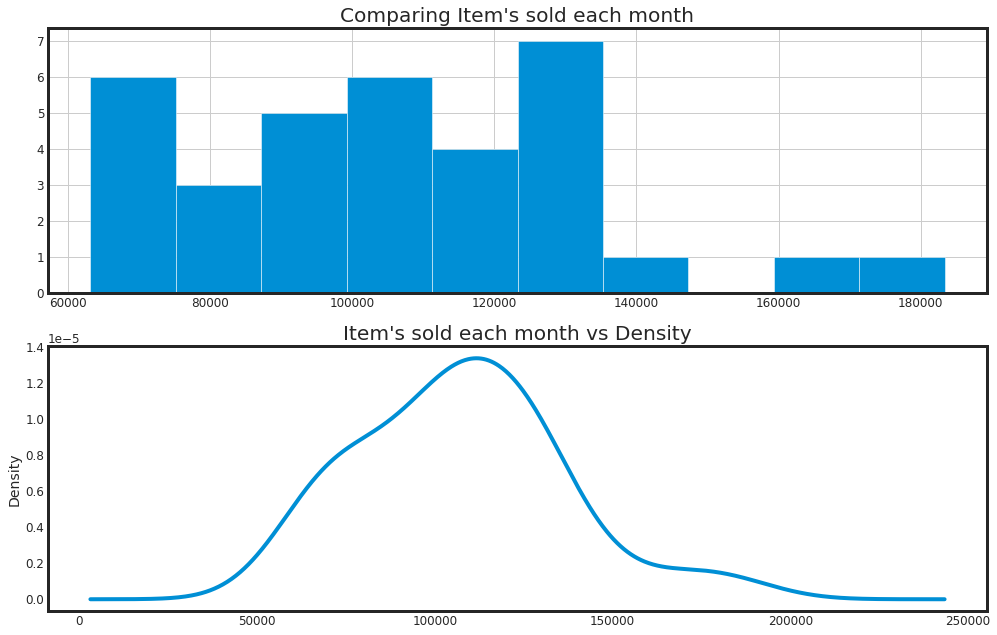

In [72]:
from pandas import Series
from matplotlib import pyplot
plt.figure(figsize=(15,10))

pyplot.subplot(211)
plt.title("Comparing Item's sold each month")
df.item_cnt_day.hist()

pyplot.subplot(212)
plt.title("Item's sold each month vs Density")
df.item_cnt_day.plot(kind='kde')

pyplot.show()

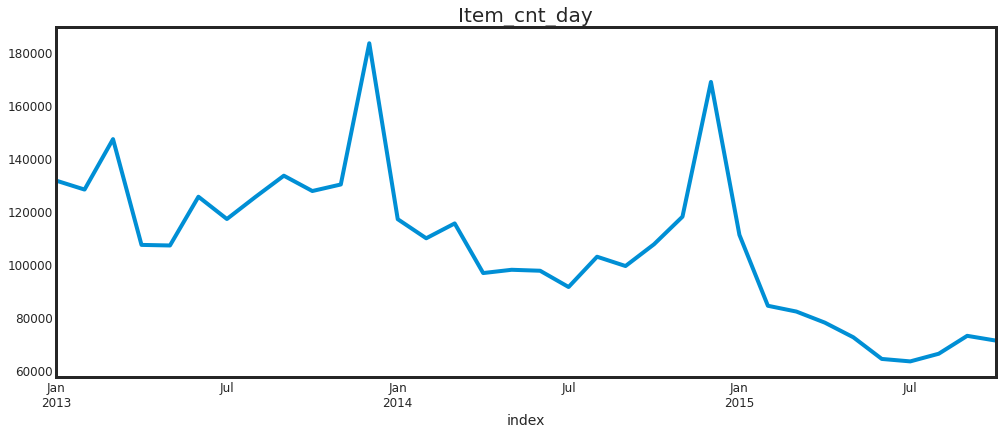

In [74]:
y.plot(figsize=(15, 6))
plt.title('Item_cnt_day',fontsize = 20)
plt.show()


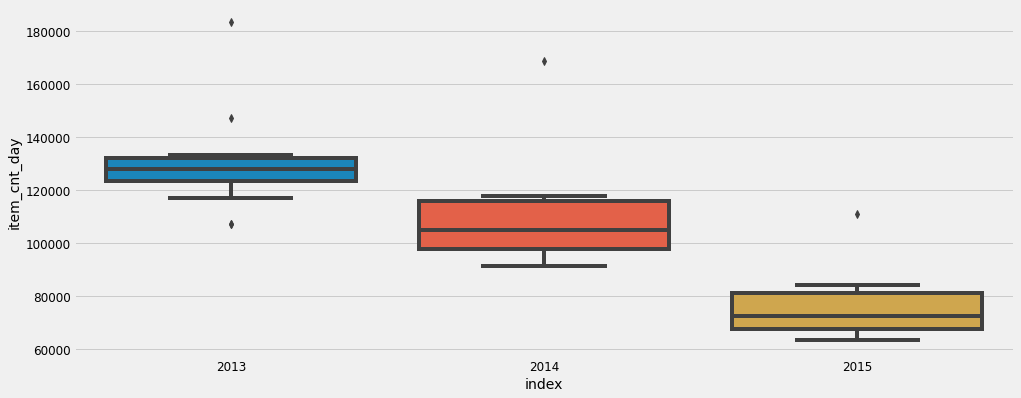

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df.item_cnt_day.index.year, df.item_cnt_day, ax=ax)

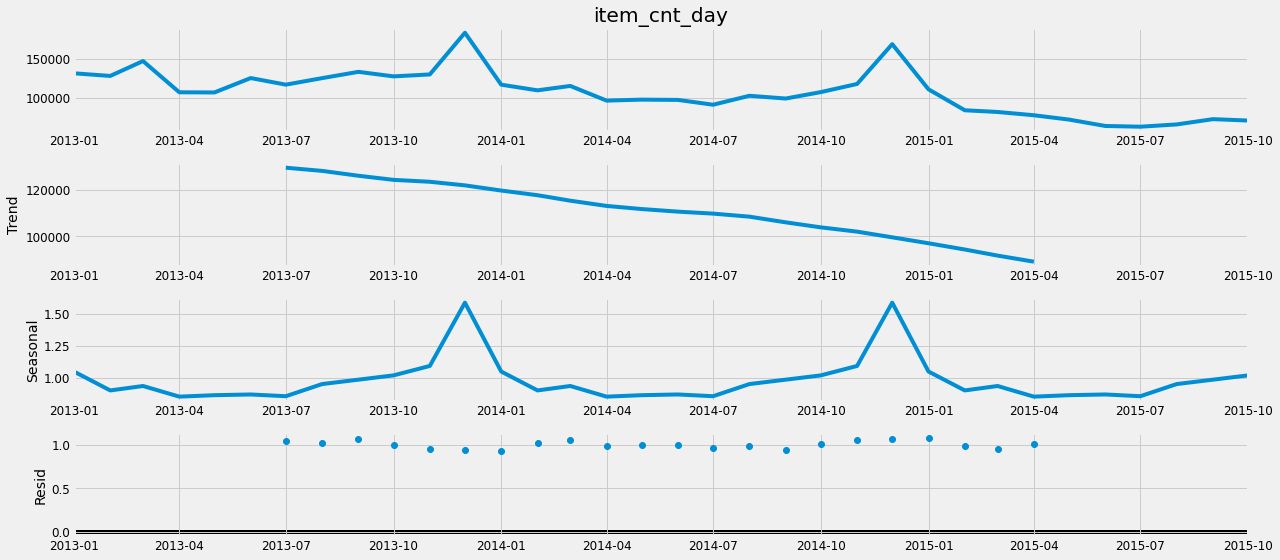

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model = 'multiplicative')
fig = decomposition.plot()
plt.show()

# Time Series Forecasting:

We have used the following models to forecast the toy sales:

* ARIMA

* Light GBM

* XGBoost

* Neural Networks

# ARIMA

In [30]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [31]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal, enforce_stationary = False,enforce_invertibility=False) 
            result = mod.fit()   
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:888.4031796000711
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:878.8688041822081
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:510.16330714664264
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:559.55687614401
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:825.0883583014804
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:823.6474108349839
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:506.3190661665517
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:486.12572548690576
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:868.0286405844311
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:867.3196461067649
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:509.3895546282867
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:504.1541804195285
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:866.4753900340535
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:868.4458501676542
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:506.550841208772
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:501.0180792734719
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:758.4724533792245
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:760.3424614672563
ARIMA(0, 1,

### Fitting The ARIMA Model

We will now fit the ARIMA model using the above optimal combination of p, d, q where we got the lowest AIC value

In [32]:
model = sm.tsa.statespace.SARIMAX(y, order = (1, 1, 1),
                                  seasonal_order = (1, 1, 0, 12)
                                 )
result = model.fit()
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2085      4.900      0.043      0.966      -9.396       9.813
ma.L1         -0.1965      5.038     -0.039      0.969     -10.071       9.678
ar.S.L12      -0.0692      0.073     -0.941      0.347      -0.213       0.075
sigma2      9.765e+07   6.15e-08   1.59e+15      0.000    9.76e+07    9.76e+07


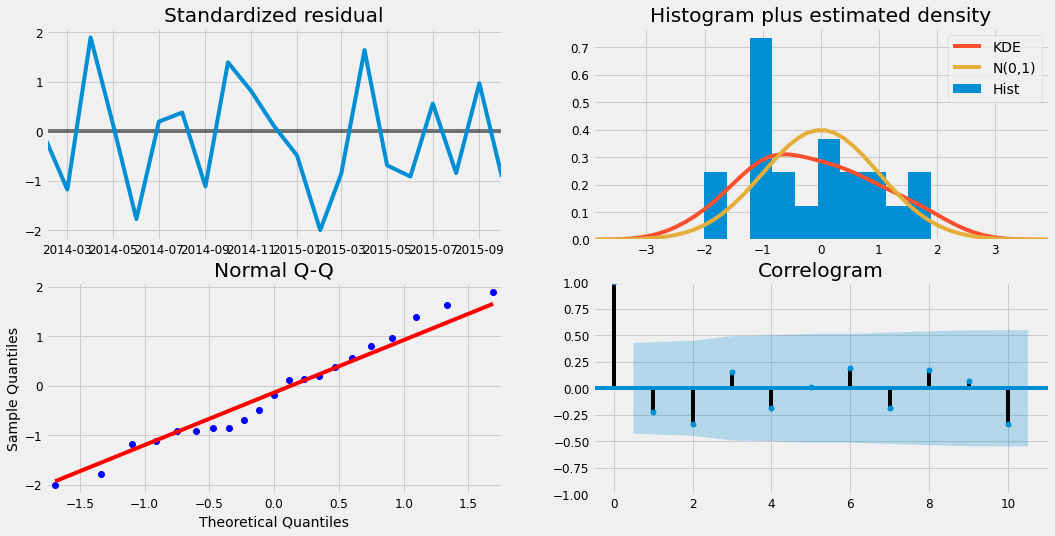

In [33]:
result.plot_diagnostics(figsize = (16, 8))
plt.show()

### Validating Forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2014–01–01 to the end of the data.

In [34]:
prediction = result.get_prediction(start = pd.to_datetime('2014-01-01'), dynamic = False)
prediction_ci = prediction.conf_int()
prediction_ci

,lower item_cnt_day,upper item_cnt_day
index,,
2014-01-01,285781.037598,324687.597000
2014-02-01,92252.093741,130988.617905
2014-03-01,107600.819922,146337.318788
2014-04-01,58474.082951,97210.580841
2014-05-01,77159.252635,115895.750487
2014-06-01,95624.249774,134360.747624
2014-07-01,70020.522875,108757.020725
2014-08-01,79647.587642,118384.085493
2014-09-01,90883.896120,129620.393971


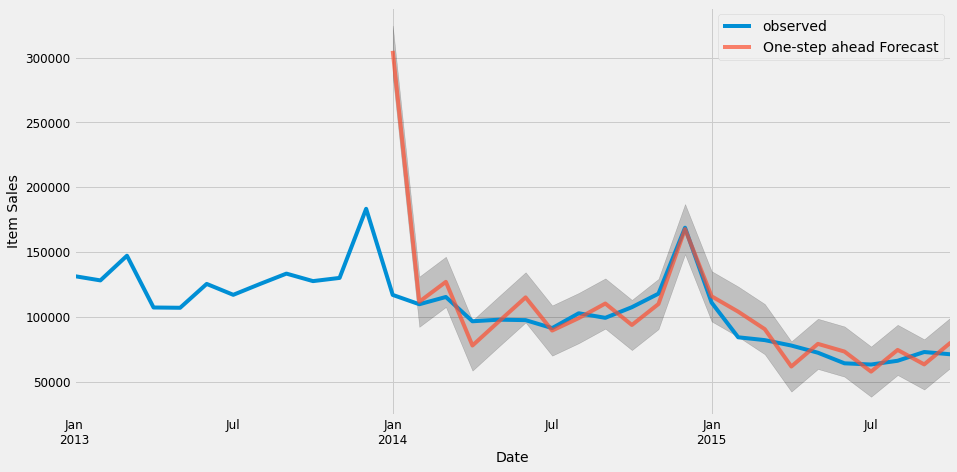

In [35]:
ax = y['2013':].plot(label = 'observed')
prediction.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.7, figsize = (14, 7))
ax.fill_between(prediction_ci.index, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax.set_xlabel("Date")
ax.set_ylabel('Item Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

### Error Analysis

In [36]:
y_hat = prediction.predicted_mean
y_truth = y['2014-01-01':]

mse = ((y_hat - y_truth) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 1718890172.84
The Root Mean Squared Error of our forecasts is 41459.5


### Producing And Visualizing forecasts through Graphs (Out of Sample data)

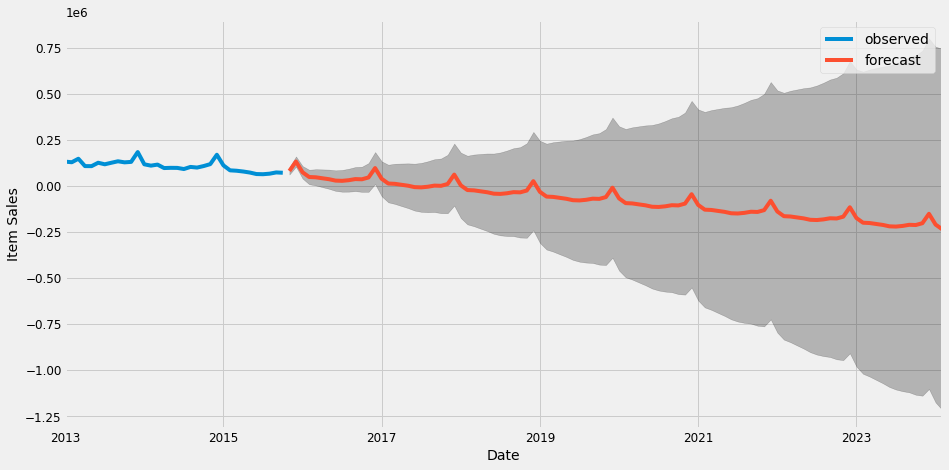

In [37]:
pred_uc = result.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label = 'observed', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax = ax, label = 'forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Item Sales')

plt.legend()
plt.show()

## Loading test data And Cleaned data

In [38]:
test =pd.read_csv('test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [39]:
train=pd.read_csv('sales_updates.csv',sep=',')
shops= pd.read_csv('shops_updates.csv',sep=',')
items=pd.read_csv('item_category_updated.csv',sep=',')

In [40]:
shops.head()

,Unnamed: 0,shop_id,city_code
0,0,0,29
1,1,1,29
2,2,2,0
3,3,3,1
4,4,4,2


## Data Preprocessing with the Cleaned data

In [41]:
from itertools import product
import time
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

10.47668981552124

In [42]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) 
                                .astype(np.float32))
time.time() - ts

4.090285539627075

In [43]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [44]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) 
time.time() - ts

0.06837940216064453

In [45]:
matrix = pd.merge(matrix, shops)

In [46]:
matrix = pd.merge(matrix, items)

In [47]:
matrix=matrix.drop(['Unnamed: 0'],axis=1) 

In [48]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0.0,0,2,1,10
1,0,2,27,1.0,0.0,0,2,1,10
2,0,2,28,0.0,0.0,0,2,1,10
3,0,2,29,0.0,0.0,0,2,1,10
4,0,2,32,0.0,0.0,0,2,1,10


# Light GBM Model

In [49]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

In [50]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [51]:
cat_feats = ['shop_id','city_code','item_category_id','type_code','subtype_code']

In [52]:
ts = time.time()

model = LGBMRegressor(
    max_depth = 8,
    n_estimators = 500,
    colsample_bytree=0.7,
    min_child_weight = 300,
    reg_alpha = 0.1,
    reg_lambda = 1,
    random_state = 42,
)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=10, 
    early_stopping_rounds = 40,
    categorical_feature = cat_feats) 

time.time() - ts

Training until validation scores don't improve for 40 rounds.
[10]	training's l2: 1.45093	training's rmse: 1.20454	valid_1's l2: 1.25988	valid_1's rmse: 1.12245
[20]	training's l2: 1.43604	training's rmse: 1.19835	valid_1's l2: 1.25356	valid_1's rmse: 1.11963
[30]	training's l2: 1.42696	training's rmse: 1.19455	valid_1's l2: 1.24978	valid_1's rmse: 1.11793
[40]	training's l2: 1.41543	training's rmse: 1.18972	valid_1's l2: 1.24586	valid_1's rmse: 1.11618
[50]	training's l2: 1.40866	training's rmse: 1.18687	valid_1's l2: 1.24069	valid_1's rmse: 1.11386
[60]	training's l2: 1.40399	training's rmse: 1.1849	valid_1's l2: 1.23805	valid_1's rmse: 1.11268
[70]	training's l2: 1.40075	training's rmse: 1.18353	valid_1's l2: 1.23753	valid_1's rmse: 1.11244
[80]	training's l2: 1.39837	training's rmse: 1.18253	valid_1's l2: 1.23612	valid_1's rmse: 1.11181
[90]	training's l2: 1.39598	training's rmse: 1.18151	valid_1's l2: 1.23502	valid_1's rmse: 1.11131
[100]	training's l2: 1.39439	training's rmse: 1.

75.31429290771484

In [53]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv('Xtrainlevel2.csv', index=False)

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('lgb_submission.csv', index=False)

# XGBOOST Model

In [54]:
from xgboost import XGBRegressor
ts = time.time()

model = XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    gamma = 0.005,
    eta=0.1,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=10, 
    early_stopping_rounds = 10,
    )

time.time() - ts

[11:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:14] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.18598	validation_1-rmse:1.15481
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[10]	validation_0-rmse:1.1782	validation_1-rmse:1.12661
[20]	validation_0-rmse:1.18	validation_1-rmse:1.12245
[30]	validation_0-rmse:1.1796	validation_1-rmse:1.12155
[40]	validation_0-rmse:1.17948	validation_1-rmse:1.12084
[50]	validation_0-rmse:1.17934	validation_1-rmse:1.12031
[60]	validation_0-rmse:1.17895	validation_1-rmse:1.11988
[70]	validation_0-rmse:1.17844	validation_1-rmse:1.11963
[80]	validation_0-rmse:1.17807	validation_1-rmse:1

2010.78768324852

In [55]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

In [56]:
import xgboost as xgb
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax)

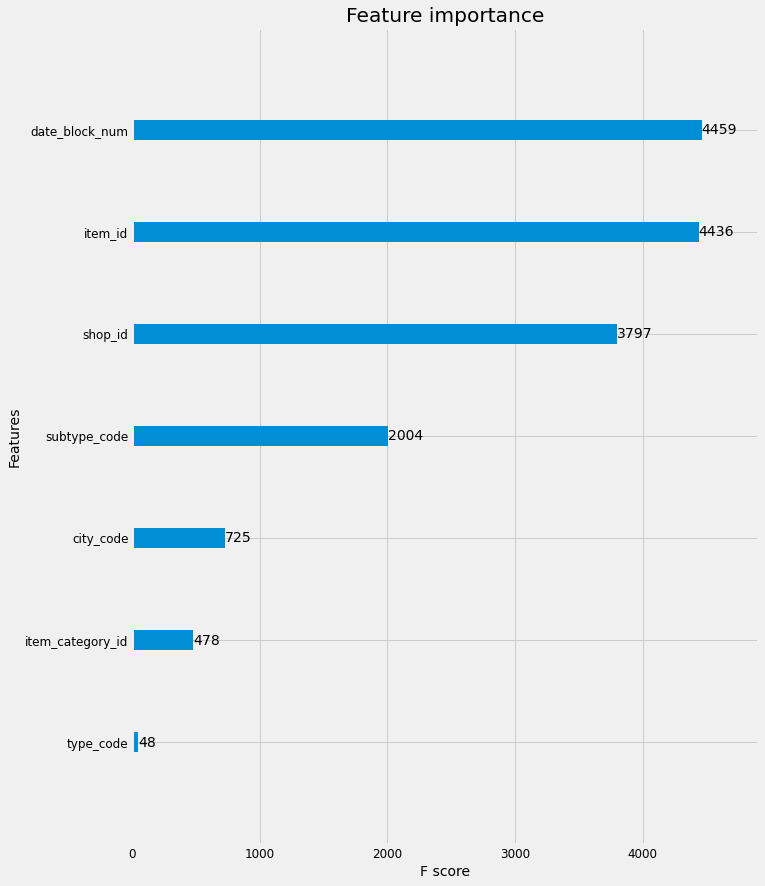

In [57]:
plot_features(model, (10,14))

# Neural Networks

In [58]:
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2, l1
from keras.optimizers import RMSprop, Adam
import tensorflow
tensorflow.random.set_seed(23333)
np.random.seed(233333)

In [59]:
def Sales_prediction_model(input_shape):
    in_layer = Input(input_shape)
    x = Dense(16,kernel_initializer='RandomUniform', kernel_regularizer=l2(0.02), activation = "relu")(in_layer)
    x = Dense(8, kernel_initializer='RandomUniform', kernel_regularizer=l2(0.02), activation = "relu")(x)
    x = Dense(1, kernel_initializer='RandomUniform', kernel_regularizer=l2(0.02), activation = "relu")(x)
    
    model = Model(inputs = in_layer, outputs = x, name='Sales_prediction_model')
    return model

# NN cannot take missing values, fill NaN with 0.
X_train.fillna(0,inplace=True)
X_valid.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

input_shape = [X_train.shape[1]]
model = Sales_prediction_model(input_shape)
model.compile(optimizer = Adam(lr=0.0005) , loss = ["mse"], metrics=['mse'])
model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid), batch_size = 10000, epochs=5)

Epoch 1/5
1068/1068 [==============================] - 5s 5ms/step - loss: 1.6116 - mse: 1.6108 - val_loss: 1.3606 - val_mse: 1.3599
Epoch 2/5
1068/1068 [==============================] - 5s 4ms/step - loss: 1.5919 - mse: 1.5912 - val_loss: 1.3605 - val_mse: 1.3599
Epoch 3/5
1068/1068 [==============================] - 5s 5ms/step - loss: 1.5918 - mse: 1.5912 - val_loss: 1.3604 - val_mse: 1.3599
Epoch 4/5
1068/1068 [==============================] - 5s 4ms/step - loss: 1.5917 - mse: 1.5912 - val_loss: 1.3603 - val_mse: 1.3599
Epoch 5/5
1068/1068 [==============================] - 5s 4ms/step - loss: 1.5489 - mse: 1.5474 - val_loss: 1.2958 - val_mse: 1.2935


In [60]:
Y_pred = model.predict(X_valid).clip(0, 20)[:,0]
Y_test = model.predict(X_test).clip(0, 20)[:,0]

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('nn_submission.csv', index=False)

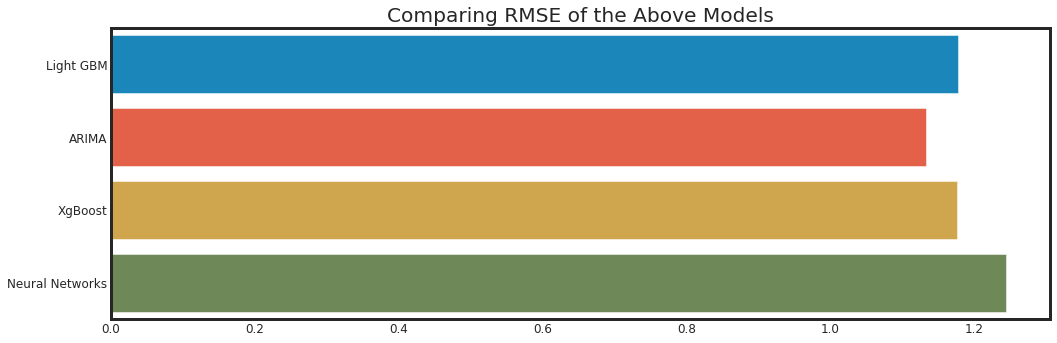

In [69]:
Model = ['Light GBM','ARIMA','XgBoost','Neural Networks']
RMSE = [1.17728,1.13305,1.17676,1.24394]
plt.figure(figsize=(15,5))
plt.title("Comparing RMSE of the Above Models")
sns.barplot(y=Model, x=RMSE ,label="Root Mean Squared Error");
plt.show()

# **Result:**
After running a range of different models for better accuracy, here's the best RMSE for each model:

* ARIMA: 1.13305
* Light GBM:1.17728
* XGBoost: 1.17676
* NN: 1.24394

The results are really close to each other. 

The best performing model is ARIMA since it has the lowest RMSE which makes it a better fit. 
